# 🧪 No-Show Prediction — Experiment Notebook

This notebook builds a **No-Show Prediction** model using **XGBoost** with **SMOTE** for handling class imbalance.

**Pipeline:**
1. Setup & Imports
2. Load Data
3. Exploratory Data Analysis (EDA)
4. Feature Engineering
5. Train/Test Split + SMOTE
6. XGBoost Model Training
7. Evaluation & Visualization
8. Save Model

---
## 1. Setup & Imports

In [1]:
# Install dependencies (uncomment and run once if needed)
# %pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn joblib

In [2]:
import pandas as pd
import numpy as np
import joblib
import os
import json
import warnings
warnings.filterwarnings("ignore")

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)

# XGBoost
from xgboost import XGBClassifier

# SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")
print("✅ All imports loaded successfully!")

✅ All imports loaded successfully!


In [3]:
# Project paths
PROJECT_ROOT = os.path.abspath(".")
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "salon_bookings.csv")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")

print(f"Project Root : {PROJECT_ROOT}")
print(f"Data Path    : {DATA_PATH}")
print(f"Models Dir   : {MODELS_DIR}")

Project Root : c:\ML_Project\Hair Rap by YoYo
Data Path    : c:\ML_Project\Hair Rap by YoYo\data\salon_bookings.csv
Models Dir   : c:\ML_Project\Hair Rap by YoYo\models


---
## 2. Load Data

In [4]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Dataset shape: 10,000 rows × 18 columns


,booking_id,customer_id,service_type,service_price,booking_date,appointment_date,appointment_hour,booking_lead_time_days,past_visit_count,past_cancellation_count,past_no_show_count,payment_method,branch,day_of_week,is_weekend,customer_age,gender,appointment_outcome
0,BK_00001,CUST_0465,Hair Coloring,2500,2025-12-12,2025-12-20,13,8,3,0,0,UPI Prepaid,Indiranagar,Saturday,1,40,Male,Show
1,BK_00002,CUST_1777,Hair Treatment,4000,2025-11-23,2025-11-24,14,1,4,0,0,Pay at Salon (Cash),Whitefield,Monday,0,31,Female,Show
2,BK_00003,CUST_1878,Hair Coloring,2500,2025-12-30,2026-01-29,19,30,2,0,0,Pay at Salon (Cash),Jayanagar,Thursday,0,18,Female,No-Show
3,BK_00004,CUST_1743,Spa & Massage,3000,2025-12-18,2025-12-20,14,2,3,0,0,Pay at Salon (Cash),Indiranagar,Saturday,1,37,Female,Show
4,BK_00005,CUST_0909,Haircut,500,2025-09-07,2025-09-08,12,1,3,0,0,Pay at Salon (Cash),Whitefield,Monday,0,29,Female,Show


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   booking_id               10000 non-null  object
 1   customer_id              10000 non-null  object
 2   service_type             10000 non-null  object
 3   service_price            10000 non-null  int64 
 4   booking_date             10000 non-null  object
 5   appointment_date         10000 non-null  object
 6   appointment_hour         10000 non-null  int64 
 7   booking_lead_time_days   10000 non-null  int64 
 8   past_visit_count         10000 non-null  int64 
 9   past_cancellation_count  10000 non-null  int64 
 10  past_no_show_count       10000 non-null  int64 
 11  payment_method           10000 non-null  object
 12  branch                   10000 non-null  object
 13  day_of_week              10000 non-null  object
 14  is_weekend               10000 non-null

In [6]:
df.describe()

,service_price,appointment_hour,booking_lead_time_days,past_visit_count,past_cancellation_count,past_no_show_count,is_weekend,customer_age
count,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3008.850000,14.64380,5.49520,5.423900,0.078200,0.045500,0.283300,32.182300
std,3684.162589,3.31916,4.97645,4.929081,0.369186,0.241735,0.450623,9.147493
min,500.000000,9.00000,1.00000,1.000000,0.000000,0.000000,0.000000,18.000000
25%,500.000000,12.00000,2.00000,2.000000,0.000000,0.000000,0.000000,25.000000
50%,2500.000000,14.00000,4.00000,4.000000,0.000000,0.000000,0.000000,32.000000
75%,3000.000000,18.00000,7.00000,7.000000,0.000000,0.000000,1.000000,38.000000
max,15000.000000,20.00000,30.00000,47.000000,10.000000,3.000000,1.000000,65.000000


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Target Distribution

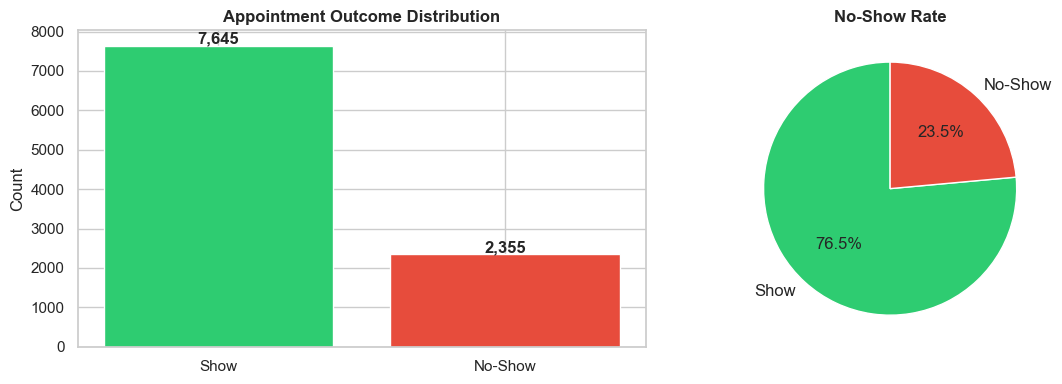


No-Show Rate: 23.5%
Class imbalance — this is why we need SMOTE!


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
target_counts = df["appointment_outcome"].value_counts()
colors = ["#2ecc71", "#e74c3c"]
axes[0].bar(target_counts.index, target_counts.values, color=colors, edgecolor="white")
axes[0].set_title("Appointment Outcome Distribution", fontweight="bold")
axes[0].set_ylabel("Count")
for i, (label, count) in enumerate(zip(target_counts.index, target_counts.values)):
    axes[0].text(i, count + 50, f"{count:,}", ha="center", fontweight="bold")

# Pie chart
axes[1].pie(target_counts.values, labels=target_counts.index, autopct="%1.1f%%",
            colors=colors, startangle=90, textprops={"fontsize": 12})
axes[1].set_title("No-Show Rate", fontweight="bold")

plt.tight_layout()
plt.show()

noshow_rate = (df['appointment_outcome'] == 'No-Show').mean()
print(f"\nNo-Show Rate: {noshow_rate:.1%}")
print(f"Class imbalance — this is why we need SMOTE!")

### 3.2 Missing Values

In [8]:
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✅ No missing values found!")
else:
    print("⚠ Missing values:")
    print(missing[missing > 0])

✅ No missing values found!


### 3.3 Key Feature Distributions

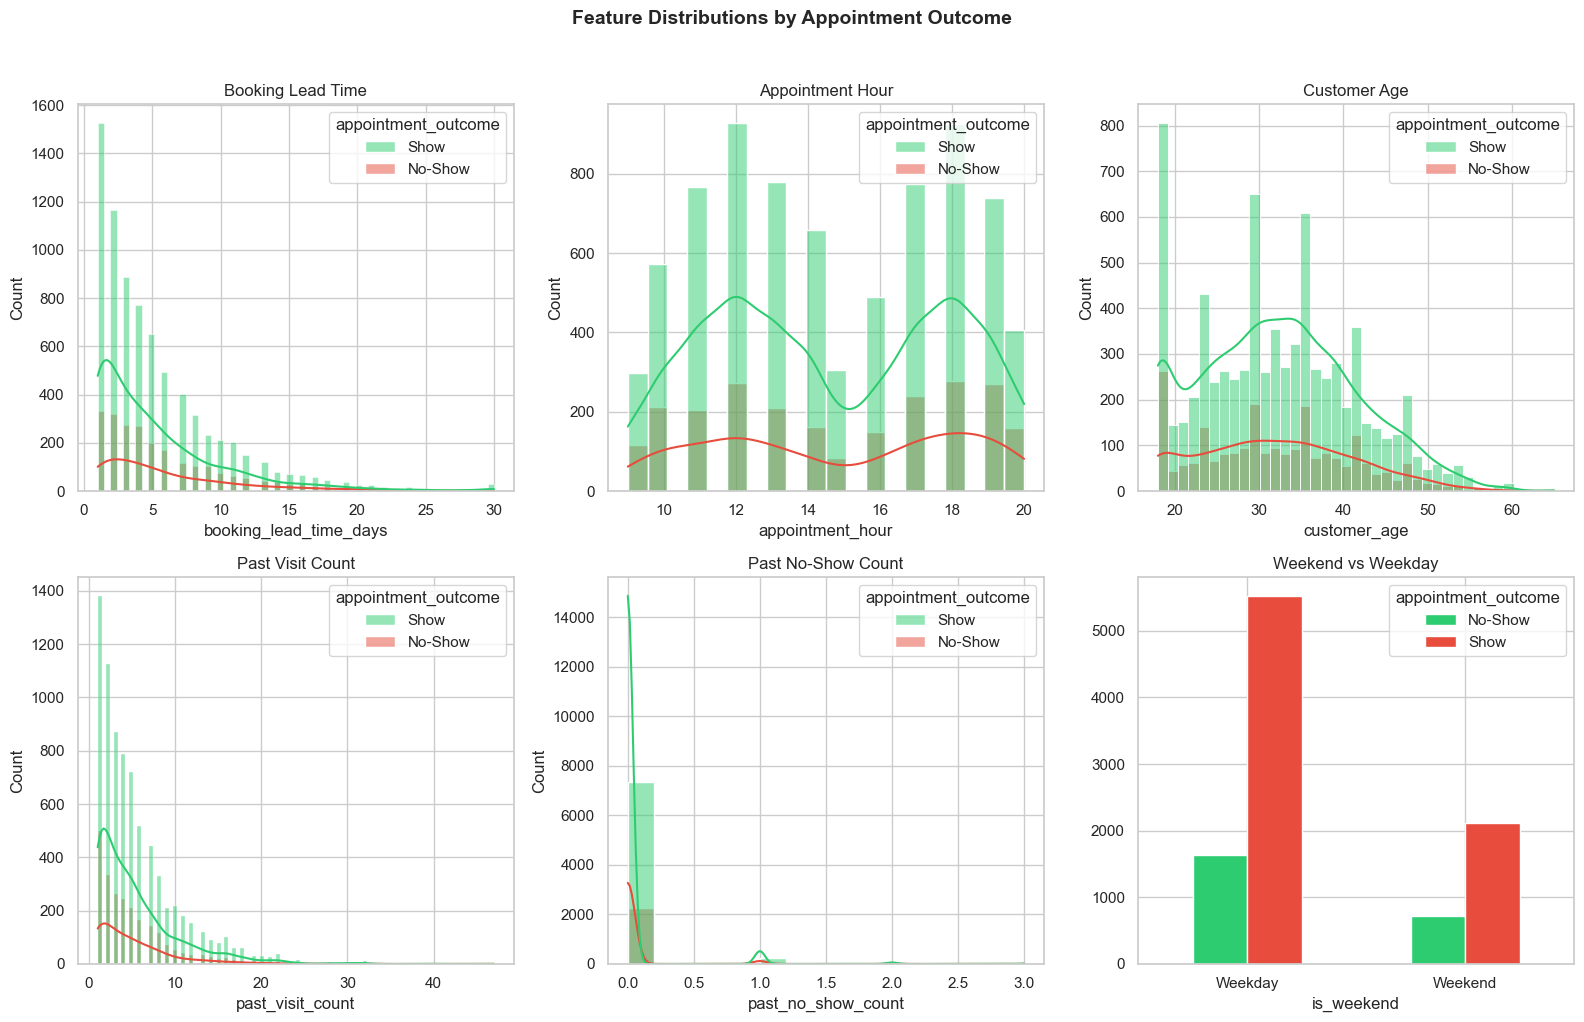

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Booking lead time
sns.histplot(data=df, x="booking_lead_time_days", hue="appointment_outcome",
             kde=True, ax=axes[0, 0], palette=colors)
axes[0, 0].set_title("Booking Lead Time")

# Appointment hour
sns.histplot(data=df, x="appointment_hour", hue="appointment_outcome",
             kde=True, ax=axes[0, 1], palette=colors)
axes[0, 1].set_title("Appointment Hour")

# Customer age
sns.histplot(data=df, x="customer_age", hue="appointment_outcome",
             kde=True, ax=axes[0, 2], palette=colors)
axes[0, 2].set_title("Customer Age")

# Past visit count
sns.histplot(data=df, x="past_visit_count", hue="appointment_outcome",
             kde=True, ax=axes[1, 0], palette=colors)
axes[1, 0].set_title("Past Visit Count")

# Past no-show count
sns.histplot(data=df, x="past_no_show_count", hue="appointment_outcome",
             kde=True, ax=axes[1, 1], palette=colors)
axes[1, 1].set_title("Past No-Show Count")

# Weekend vs Weekday
weekend_noshow = df.groupby(["is_weekend", "appointment_outcome"]).size().unstack(fill_value=0)
weekend_noshow.plot(kind="bar", ax=axes[1, 2], color=colors, edgecolor="white")
axes[1, 2].set_title("Weekend vs Weekday")
axes[1, 2].set_xticklabels(["Weekday", "Weekend"], rotation=0)

plt.suptitle("Feature Distributions by Appointment Outcome", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

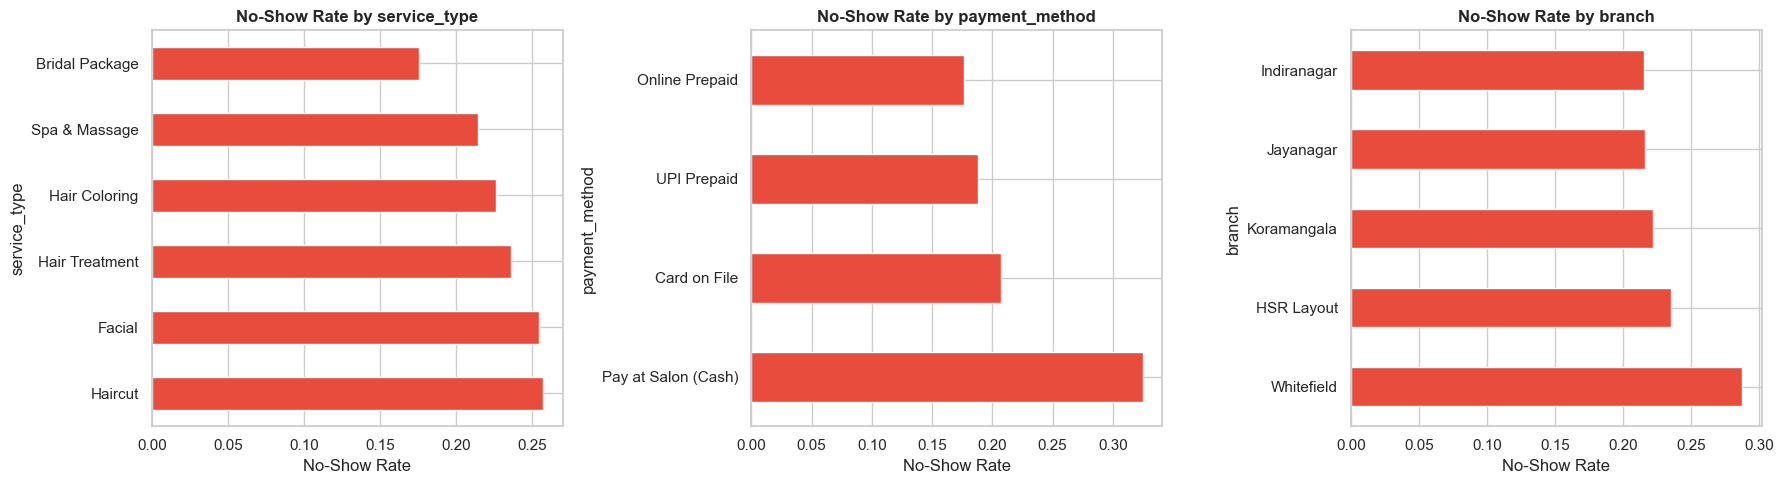

In [10]:
# No-show rate by categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, ["service_type", "payment_method", "branch"]):
    noshow_rate = df.groupby(col)["appointment_outcome"].apply(
        lambda x: (x == "No-Show").mean()
    ).sort_values(ascending=False)
    noshow_rate.plot(kind="barh", ax=ax, color="#e74c3c", edgecolor="white")
    ax.set_title(f"No-Show Rate by {col}", fontweight="bold")
    ax.set_xlabel("No-Show Rate")

plt.tight_layout()
plt.show()

---
## 4. Feature Engineering

Replicating the logic from `src/feature_engineering.py` inline for full control.

In [11]:
data = df.copy()

# ── Derived Features ────────────────────────────────────────────────────
# No-show ratio: historical no-show tendency
data["no_show_ratio"] = data["past_no_show_count"] / (data["past_visit_count"] + 1)

# Cancellation ratio: historical cancellation tendency
data["cancellation_ratio"] = data["past_cancellation_count"] / (data["past_visit_count"] + 1)

# Is new customer (first visit)
data["is_new_customer"] = (data["past_visit_count"] <= 1).astype(int)

# Is loyal customer (10+ visits)
data["is_loyal_customer"] = (data["past_visit_count"] >= 10).astype(int)

# Lead time buckets
data["lead_time_bucket"] = pd.cut(
    data["booking_lead_time_days"],
    bins=[0, 1, 3, 7, 14, 30],
    labels=["same_day", "1-3_days", "4-7_days", "1-2_weeks", "2+_weeks"],
    include_lowest=True
)

# Hour buckets
data["hour_bucket"] = pd.cut(
    data["appointment_hour"],
    bins=[8, 11, 14, 17, 21],
    labels=["morning", "midday", "afternoon", "evening"],
    include_lowest=True
)

# Age group
data["age_group"] = pd.cut(
    data["customer_age"],
    bins=[17, 25, 35, 45, 65],
    labels=["18-25", "26-35", "36-45", "46+"],
    include_lowest=True
)

print("✅ Derived features created")
print(f"   no_show_ratio, cancellation_ratio, is_new_customer, is_loyal_customer,")
print(f"   lead_time_bucket, hour_bucket, age_group")

✅ Derived features created
   no_show_ratio, cancellation_ratio, is_new_customer, is_loyal_customer,
   lead_time_bucket, hour_bucket, age_group


In [12]:
# ── Encode Categoricals ────────────────────────────────────────────────
categorical_cols = [
    "service_type", "payment_method", "branch", "day_of_week",
    "gender", "lead_time_bucket", "hour_bucket", "age_group"
]

label_encoders = {}
for col in categorical_cols:
    data[col] = data[col].astype(str)
    le = LabelEncoder()
    data[col + "_encoded"] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"  Encoded: {col} → {len(le.classes_)} classes")

print("\n✅ All categorical features encoded")

  Encoded: service_type → 6 classes
  Encoded: payment_method → 4 classes
  Encoded: branch → 5 classes
  Encoded: day_of_week → 7 classes
  Encoded: gender → 3 classes
  Encoded: lead_time_bucket → 5 classes
  Encoded: hour_bucket → 4 classes
  Encoded: age_group → 4 classes

✅ All categorical features encoded


In [13]:
# ── Select Feature Columns ─────────────────────────────────────────────
feature_cols = [
    "booking_lead_time_days",
    "appointment_hour",
    "past_visit_count",
    "past_cancellation_count",
    "past_no_show_count",
    "is_weekend",
    "customer_age",
    "no_show_ratio",
    "cancellation_ratio",
    "is_new_customer",
    "is_loyal_customer",
    "service_type_encoded",
    "payment_method_encoded",
    "branch_encoded",
    "day_of_week_encoded",
    "gender_encoded",
    "lead_time_bucket_encoded",
    "hour_bucket_encoded",
    "age_group_encoded",
]

# Human-readable feature names for display
feature_name_map = {
    "booking_lead_time_days": "Booking Lead Time (days)",
    "appointment_hour": "Appointment Hour",
    "past_visit_count": "Past Visit Count",
    "past_cancellation_count": "Past Cancellation Count",
    "past_no_show_count": "Past No-Show Count",
    "is_weekend": "Is Weekend",
    "customer_age": "Customer Age",
    "no_show_ratio": "Historical No-Show Ratio",
    "cancellation_ratio": "Historical Cancellation Ratio",
    "is_new_customer": "Is New Customer",
    "is_loyal_customer": "Is Loyal Customer",
    "service_type_encoded": "Service Type",
    "payment_method_encoded": "Payment Method",
    "branch_encoded": "Branch",
    "day_of_week_encoded": "Day of Week",
    "gender_encoded": "Gender",
    "lead_time_bucket_encoded": "Lead Time Bucket",
    "hour_bucket_encoded": "Hour Bucket",
    "age_group_encoded": "Age Group",
}

X = data[feature_cols]
y = (data["appointment_outcome"] == "No-Show").astype(int)

print(f"✅ Feature matrix: {X.shape}")
print(f"   Target: Show={int((y == 0).sum()):,} | No-Show={int(y.sum()):,}")
X.head()

✅ Feature matrix: (10000, 19)
   Target: Show=7,645 | No-Show=2,355


,booking_lead_time_days,appointment_hour,past_visit_count,past_cancellation_count,past_no_show_count,is_weekend,customer_age,no_show_ratio,cancellation_ratio,is_new_customer,is_loyal_customer,service_type_encoded,payment_method_encoded,branch_encoded,day_of_week_encoded,gender_encoded,lead_time_bucket_encoded,hour_bucket_encoded,age_group_encoded
0,8,13,3,0,0,1,40,0.0,0.0,0,0,2,3,1,2,1,0,2,2
1,1,14,4,0,0,0,31,0.0,0.0,0,0,3,2,4,1,0,4,2,1
2,30,19,2,0,0,0,18,0.0,0.0,0,0,2,2,2,4,0,2,1,0
3,2,14,3,0,0,1,37,0.0,0.0,0,0,5,2,1,2,0,1,2,2
4,1,12,3,0,0,0,29,0.0,0.0,0,0,4,2,4,1,0,4,2,1


---
## 5. Train/Test Split + SMOTE

We apply **SMOTE (Synthetic Minority Over-sampling Technique)** to the **training set only** to handle the class imbalance. The test set remains untouched to give a realistic evaluation.

In [14]:
# Split first — SMOTE is applied ONLY on training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Before SMOTE:")
print(f"  Train set: {X_train.shape[0]:,} samples")
print(f"    Show:    {int((y_train == 0).sum()):,}")
print(f"    No-Show: {int(y_train.sum()):,}")
print(f"  Test set:  {X_test.shape[0]:,} samples")

Before SMOTE:
  Train set: 8,000 samples
    Show:    6,116
    No-Show: 1,884
  Test set:  2,000 samples


In [15]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
print(f"  Train set: {X_train_smote.shape[0]:,} samples")
print(f"    Show:    {int((y_train_smote == 0).sum()):,}")
print(f"    No-Show: {int(y_train_smote.sum()):,}")
print(f"\n✅ Classes are now balanced!")

After SMOTE:
  Train set: 12,232 samples
    Show:    6,116
    No-Show: 6,116

✅ Classes are now balanced!


  File "c:\Users\abhir\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\abhir\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abhir\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\abhir\anaconda3\Lib\subprocess.

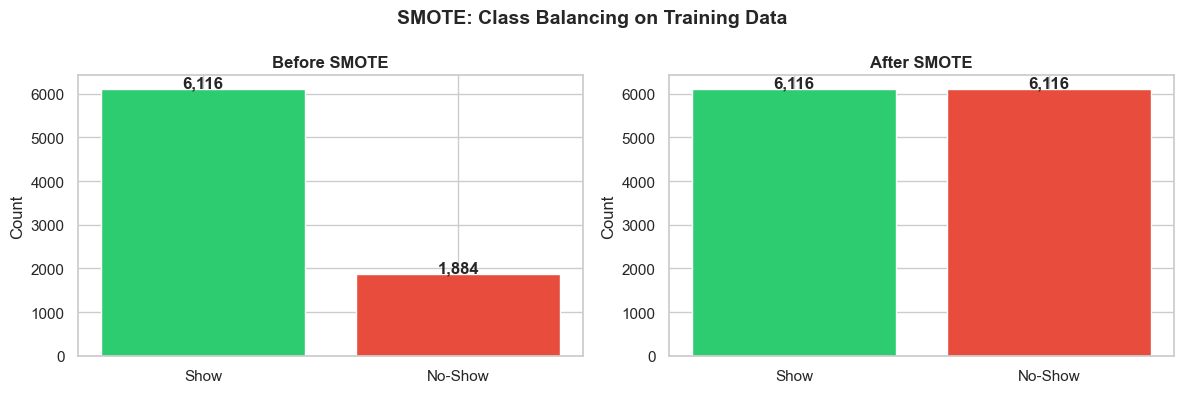

In [16]:
# Visualize before vs after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
before_counts = [int((y_train == 0).sum()), int(y_train.sum())]
axes[0].bar(["Show", "No-Show"], before_counts, color=["#2ecc71", "#e74c3c"], edgecolor="white")
axes[0].set_title("Before SMOTE", fontweight="bold")
axes[0].set_ylabel("Count")
for i, count in enumerate(before_counts):
    axes[0].text(i, count + 30, f"{count:,}", ha="center", fontweight="bold")

# After SMOTE
after_counts = [int((y_train_smote == 0).sum()), int(y_train_smote.sum())]
axes[1].bar(["Show", "No-Show"], after_counts, color=["#2ecc71", "#e74c3c"], edgecolor="white")
axes[1].set_title("After SMOTE", fontweight="bold")
axes[1].set_ylabel("Count")
for i, count in enumerate(after_counts):
    axes[1].text(i, count + 30, f"{count:,}", ha="center", fontweight="bold")

plt.suptitle("SMOTE: Class Balancing on Training Data", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
## 6. XGBoost Model Training

In [17]:
# XGBoost hyperparameters
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    verbosity=0,
    # Note: We do NOT use scale_pos_weight since SMOTE already balances the classes
)

print("🔄 Training XGBoost on SMOTE-resampled data...")
xgb_model.fit(X_train_smote, y_train_smote)
print("✅ XGBoost training complete!")

🔄 Training XGBoost on SMOTE-resampled data...
✅ XGBoost training complete!


In [18]:
# Predictions on the ORIGINAL (untouched) test set
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Custom threshold (0.8) — only flag as No-Show when model is 80%+ confident
THRESHOLD = 0.8
y_pred = (y_proba >= THRESHOLD).astype(int)

print(f"✅ Predictions generated with threshold = {THRESHOLD}")
print(f"   Predicted No-Shows: {y_pred.sum()} out of {len(y_pred)} test samples")

✅ Predictions generated with threshold = 0.8
   Predicted No-Shows: 8 out of 2000 test samples


---
## 7. Evaluation & Visualization

### 7.1 Metrics Summary

In [19]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_proba),
}

print("=" * 50)
print(f"  XGBoost + SMOTE — Threshold = {THRESHOLD}")
print("=" * 50)
for name, value in metrics.items():
    bar = "█" * int(value * 30)
    print(f"  {name:12s}: {value:.4f}  {bar}")
print("=" * 50)

  XGBoost + SMOTE — Threshold = 0.8
  Accuracy    : 0.7635  ██████████████████████
  Precision   : 0.3750  ███████████
  Recall      : 0.0064  
  F1 Score    : 0.0125  
  AUC-ROC     : 0.5582  ████████████████


### 7.2 Classification Report

In [20]:
print(f"Classification Report — XGBoost + SMOTE (Threshold = {THRESHOLD})")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=["Show", "No-Show"]))

Classification Report — XGBoost + SMOTE (Threshold = 0.8)
              precision    recall  f1-score   support

        Show       0.77      1.00      0.87      1529
     No-Show       0.38      0.01      0.01       471

    accuracy                           0.76      2000
   macro avg       0.57      0.50      0.44      2000
weighted avg       0.67      0.76      0.66      2000



### 7.3 Confusion Matrix

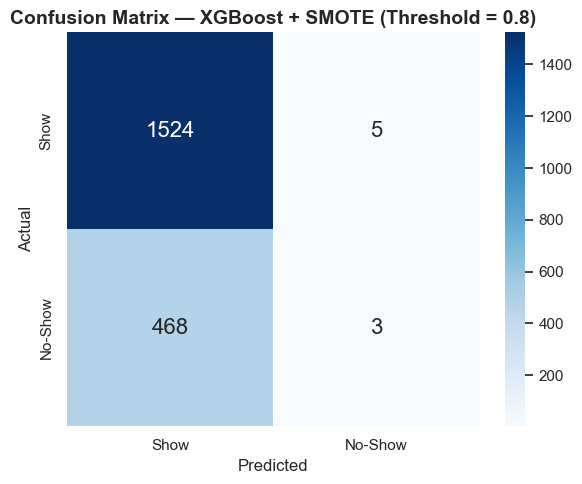


True Positives (correct No-Show):  3
False Positives (false alarm):      5
True Negatives (correct Show):      1524
False Negatives (missed No-Show):   468


In [21]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=["Show", "No-Show"],
            yticklabels=["Show", "No-Show"],
            annot_kws={"size": 16})
ax.set_title(f"Confusion Matrix — XGBoost + SMOTE (Threshold = {THRESHOLD})", fontsize=14, fontweight="bold")
ax.set_ylabel("Actual", fontsize=12)
ax.set_xlabel("Predicted", fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTrue Positives (correct No-Show):  {cm[1][1]}")
print(f"False Positives (false alarm):      {cm[0][1]}")
print(f"True Negatives (correct Show):      {cm[0][0]}")
print(f"False Negatives (missed No-Show):   {cm[1][0]}")

### 7.4 ROC Curve

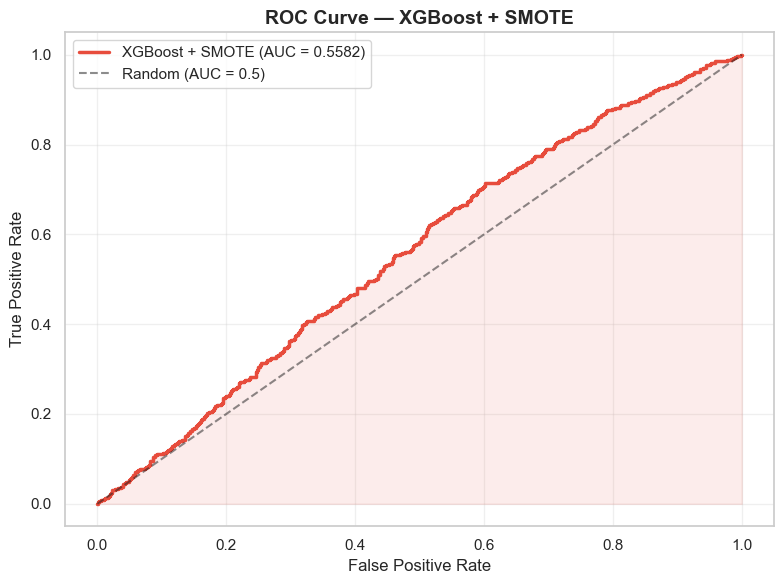

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label=f"XGBoost + SMOTE (AUC = {auc_score:.4f})", color="#e74c3c", linewidth=2.5)
ax.plot([0, 1], [0, 1], "k--", alpha=0.5, label="Random (AUC = 0.5)")
ax.fill_between(fpr, tpr, alpha=0.1, color="#e74c3c")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curve — XGBoost + SMOTE", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7.5 Feature Importance

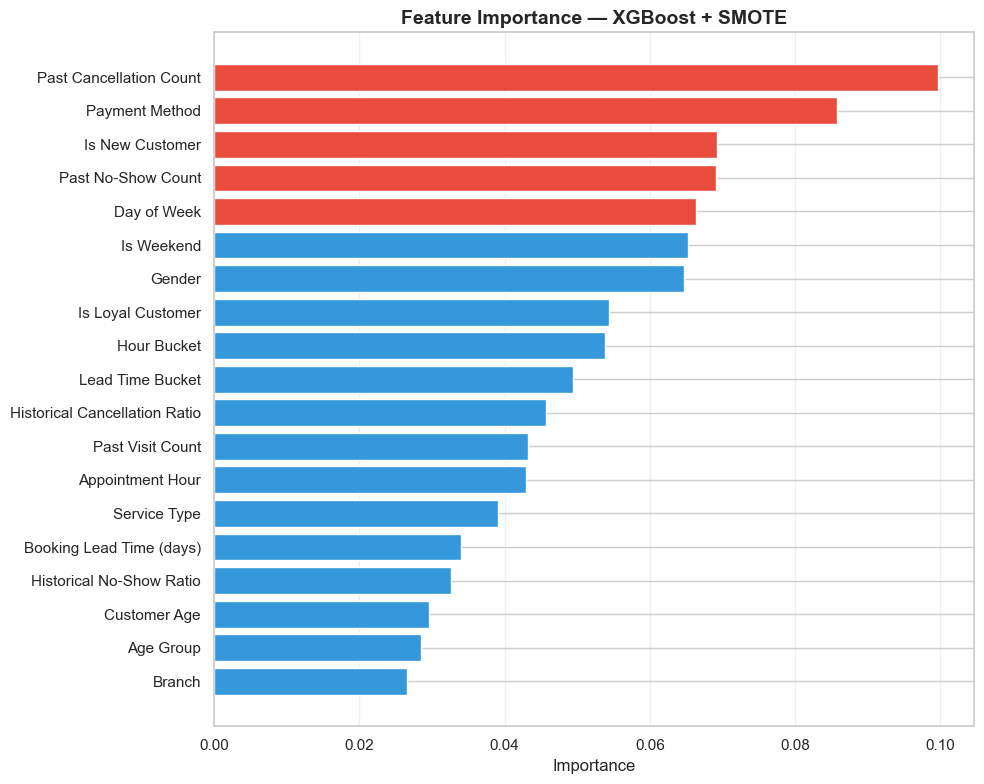


📊 Top 10 Features:
  Past Cancellation Count             0.0997 █████████
  Payment Method                      0.0858 ████████
  Is New Customer                     0.0692 ██████
  Past No-Show Count                  0.0691 ██████
  Day of Week                         0.0664 ██████
  Is Weekend                          0.0653 ██████
  Gender                              0.0647 ██████
  Is Loyal Customer                   0.0543 █████
  Hour Bucket                         0.0539 █████
  Lead Time Bucket                    0.0494 ████


In [23]:
fi_df = pd.DataFrame({
    "feature": X.columns,
    "display_name": [feature_name_map.get(f, f) for f in X.columns],
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bar_colors = ["#3498db"] * len(fi_df)
# Highlight top 5 features in red
for i in range(-5, 0):
    bar_colors[i] = "#e74c3c"

ax.barh(fi_df["display_name"], fi_df["importance"], color=bar_colors, edgecolor="white")
ax.set_xlabel("Importance", fontsize=12)
ax.set_title("Feature Importance — XGBoost + SMOTE", fontsize=14, fontweight="bold")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
for _, row in fi_df.sort_values("importance", ascending=False).head(10).iterrows():
    bar = "█" * int(row["importance"] * 100)
    print(f"  {row['display_name']:35s} {row['importance']:.4f} {bar}")

### 7.6 Prediction Probability Distribution

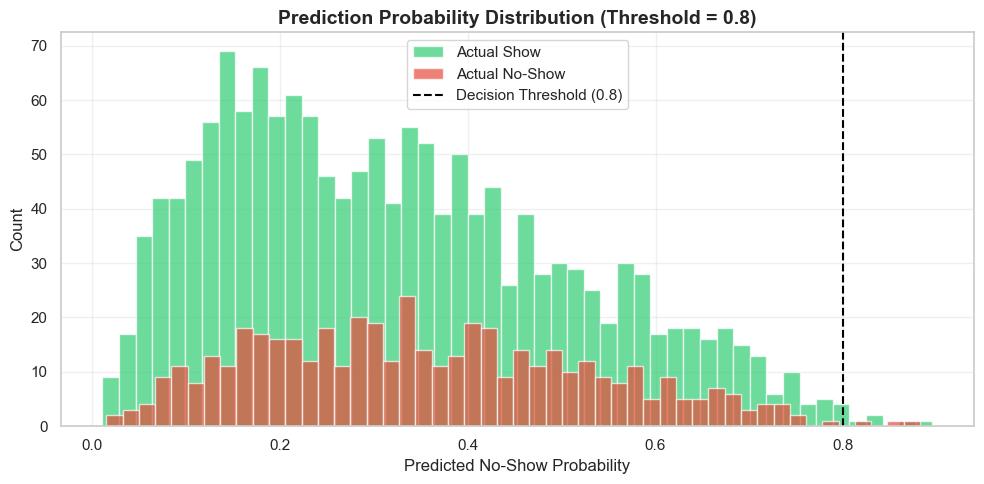

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_proba[y_test == 0], bins=50, alpha=0.7, label="Actual Show", color="#2ecc71", edgecolor="white")
ax.hist(y_proba[y_test == 1], bins=50, alpha=0.7, label="Actual No-Show", color="#e74c3c", edgecolor="white")
ax.axvline(x=THRESHOLD, color="black", linestyle="--", linewidth=1.5, label=f"Decision Threshold ({THRESHOLD})")
ax.set_xlabel("Predicted No-Show Probability", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title(f"Prediction Probability Distribution (Threshold = {THRESHOLD})", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 7.7 Threshold Comparison

In [25]:
# Compare different thresholds to understand the trade-off
print(f"{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'F1':<10} {'Accuracy':<10}")
print("=" * 54)
for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    y_pred_t = (y_proba >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    p = precision_score(y_test, y_pred_t, zero_division=0)
    f = f1_score(y_test, y_pred_t)
    a = accuracy_score(y_test, y_pred_t)
    marker = " ◄── current" if t == THRESHOLD else ""
    print(f"  {t:<10} {r:<10.4f} {p:<12.4f} {f:<10.4f} {a:<10.4f}{marker}")

Threshold    Recall     Precision    F1         Accuracy  
  0.2        0.7749     0.2581       0.3873     0.4225    
  0.3        0.5754     0.2636       0.3616     0.5215    
  0.4        0.3949     0.2768       0.3255     0.6145    
  0.5        0.2208     0.2653       0.2410     0.6725    
  0.6        0.1040     0.2634       0.1492     0.7205    
  0.7        0.0318     0.2419       0.0563     0.7485    
  0.8        0.0064     0.3750       0.0125     0.7635     ◄── current
  0.9        0.0000     0.0000       0.0000     0.7645    


---
## 8. Save Model

In [26]:
os.makedirs(MODELS_DIR, exist_ok=True)

# Save XGBoost model
model_path = os.path.join(MODELS_DIR, "best_model.pkl")
joblib.dump(xgb_model, model_path)
print(f"✅ Model saved:      {model_path}")

# Save label encoders
encoders_path = os.path.join(MODELS_DIR, "label_encoders.pkl")
joblib.dump(label_encoders, encoders_path)
print(f"✅ Encoders saved:   {encoders_path}")

# Save model comparison (single model row)
results_df = pd.DataFrame({"XGBoost_SMOTE": metrics}).T
results_path = os.path.join(MODELS_DIR, "model_comparison.csv")
results_df.to_csv(results_path)
print(f"✅ Comparison saved: {results_path}")

# Save feature importances
fi_save = pd.DataFrame({
    "feature": X.columns,
    "feature_display": [feature_name_map.get(f, f) for f in X.columns],
    "importance": xgb_model.feature_importances_
}).sort_values("importance", ascending=False)
fi_path = os.path.join(MODELS_DIR, "feature_importance.csv")
fi_save.to_csv(fi_path, index=False)
print(f"✅ Feature imp saved: {fi_path}")

# Save metadata
metadata = {
    "best_model_name": "XGBoost_SMOTE",
    "threshold": THRESHOLD,
    "metrics": metrics,
    "n_features": X.shape[1],
    "n_train_original": len(X_train),
    "n_train_after_smote": len(X_train_smote),
    "n_test": len(X_test),
    "feature_columns": list(X.columns),
    "smote_applied": True,
}
metadata_path = os.path.join(MODELS_DIR, "model_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved:   {metadata_path}")

# Save confusion matrix
cm_path = os.path.join(MODELS_DIR, "confusion_matrix.csv")
pd.DataFrame(cm, index=["Actual Show", "Actual No-Show"], columns=["Pred Show", "Pred No-Show"]).to_csv(cm_path)
print(f"✅ Confusion matrix: {cm_path}")

print("\n" + "=" * 50)
print(f"  🎉 Pipeline complete! (Threshold = {THRESHOLD})")
print("=" * 50)

✅ Model saved:      c:\ML_Project\Hair Rap by YoYo\models\best_model.pkl
✅ Encoders saved:   c:\ML_Project\Hair Rap by YoYo\models\label_encoders.pkl
✅ Comparison saved: c:\ML_Project\Hair Rap by YoYo\models\model_comparison.csv
✅ Feature imp saved: c:\ML_Project\Hair Rap by YoYo\models\feature_importance.csv
✅ Metadata saved:   c:\ML_Project\Hair Rap by YoYo\models\model_metadata.json
✅ Confusion matrix: c:\ML_Project\Hair Rap by YoYo\models\confusion_matrix.csv

  🎉 Pipeline complete! (Threshold = 0.8)


---
## 🧪 Experiment Space

Use the cells below to try new ideas — different hyperparameters, SMOTE variants, etc.

In [27]:
# Try your experiments here!
#
# Example 1: Tune XGBoost hyperparameters with GridSearchCV
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     "n_estimators": [200, 300, 500],
#     "max_depth": [4, 6, 8],
#     "learning_rate": [0.01, 0.05, 0.1],
# }
# grid = GridSearchCV(XGBClassifier(random_state=42, eval_metric="logloss", verbosity=0),
#                     param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1)
# grid.fit(X_train_smote, y_train_smote)
# print(f"Best params: {grid.best_params_}")
# print(f"Best AUC-ROC: {grid.best_score_:.4f}")
#
# Example 2: Try different SMOTE variants
# from imblearn.over_sampling import BorderlineSMOTE, ADASYN
# smote_bl = BorderlineSMOTE(random_state=42)
# X_train_bl, y_train_bl = smote_bl.fit_resample(X_train, y_train)